### Data Pre-processing before fitting linear regression 

In [1]:
import pandas as pd
import cPickle as pickle
%matplotlib inline

In [2]:
with open('df_amenities_neighbourhood_all_processed.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
# Take only columns which are required for price prediction task
cols = ['price', 'minimum_nights', 'number_of_reviews', 'instant_bookable', 'cancellation_policy', 
        'calculated_host_listings_count', 'num_page_saved',
        u'property_type','room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
        'Elevator in building', 'Internet', 'Family/kid friendly', 
        'Wireless Internet', 'Buzzer/wireless intercom', 'Kitchen', 'Doorman', 'Wheelchair accessible',
        'Cable TV', 'Hot tub', 'Gym', 'Pool', 'TV', 'Dryer', 'Washer', 'Essentials', 'Shampoo', 'Heating',
        'Air conditioning', 'Pets allowed', 'Suitable for events','Smoking allowed', 'Indoor fireplace', 
        'Breakfast', 'Laptop friendly workspace', 'Iron', 'Hangers', 'Hair dryer', 'Private living room',
        'Private entrance', 'Parking',
        'restaurant', 'atm', 'cinema', 'hospital', 'nightclub', 'park', 'mall', 'gallery', 'museum',
        'supermarket', 'bus_stop']
df = df.ix[:, cols]
print df.shape

(9232, 56)


In [4]:
# Convert 'minimum_nights' to categorical variable
# MN1 - min nights = 1
# MN2 - min nights = 2
# MN3 - min nights = 3
# MN_ - min nights > 3 
min_nights = {1:'MN1', 2:'MN2', 3:'MN3'}
df['minimum_nights'] = ['MN_' if mn>3 else min_nights[mn] for mn in df['minimum_nights']]
print df['minimum_nights'].value_counts()

MN1    3921
MN2    2554
MN_    1568
MN3    1189
Name: minimum_nights, dtype: int64


In [5]:
# Convert 'number_of_reviews' to categorical variable
# O - if 0 reviews
# L - if 1-10 reviews
# M - if 11-100 reviews
# H - if >100 reviews

for i in range(df.shape[0]):
    n_reviews =  df.ix[i, 'number_of_reviews']
    review_cat = 'H'
    if n_reviews == 0:
        review_cat = 'O'
    elif n_reviews <=10:
        review_cat = 'L'
    elif n_reviews <=100:
        review_cat = 'M'
    df.ix[i, 'number_of_reviews'] = review_cat
    
print df['number_of_reviews'].value_counts()

L    4191
M    3143
O    1710
H     188
Name: number_of_reviews, dtype: int64


In [6]:
df['instant_bookable'].value_counts()

f    7786
t    1446
Name: instant_bookable, dtype: int64

In [7]:
df['cancellation_policy'].value_counts()

strict      3461
flexible    3117
moderate    2654
Name: cancellation_policy, dtype: int64

In [8]:
# Convert 'calculated_host_listings_count' to categorical variable
# S - Single Listing if 1 
# M - Multiple Listings if > 1 
for i in range(df.shape[0]):
    count =  df.ix[i, 'calculated_host_listings_count']
    listing_cat = 'S'
    if count > 1:
        listing_cat = 'M'
    df.ix[i, 'calculated_host_listings_count'] = listing_cat
    
df['calculated_host_listings_count'].value_counts()

S    5604
M    3628
Name: calculated_host_listings_count, dtype: int64

In [9]:
# Convert 'num_page_saved' to categorical variable
# L - if 1-10 
# M - if 11-100 
# H - if >100 
for i in range(df.shape[0]):
    n_saved =  df.ix[i, 'num_page_saved']
    saved_cat = 'H'
    if n_saved <= 10:
        saved_cat = 'L'
    elif n_saved <=100:
        saved_cat = 'M'
    df.ix[i, 'num_page_saved'] = saved_cat
    
print df['num_page_saved'].value_counts()

M    4483
H    2711
L    2038
Name: num_page_saved, dtype: int64


In [10]:
# The columns property_type and bed_type have many values that correspond to very few records
# For instances that have very small frequency count, we replace it with other
df.loc[-df.property_type.isin(['House', 'Apartment', 'Condominium']), 'property_type'] = 'Other'
df.loc[-df.bed_type.isin(['Real Bed']), 'bed_type'] = 'Other'

In [11]:
# Remove NULL instances/records in columns - #bathrooms, #bedrooms, #beds
df = df.drop(df[df.beds.isnull()].index)
df = df.drop(df[df.bedrooms.isnull()].index)
df = df.drop(df[df.bathrooms.isnull()].index)
df = df.reset_index(drop=True)
df.shape

(9202, 56)

In [12]:
# All the above variables are cateforical and need to be ONE-HOT encoded
# Done using PANDAS dummy variable creation
# Example
pd.get_dummies(df['cancellation_policy']).head()

,flexible,moderate,strict
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [13]:
df = pd.concat([df, pd.get_dummies(df['minimum_nights'], prefix='minimum_nights')], axis=1)
df = pd.concat([df, pd.get_dummies(df['number_of_reviews'], prefix='number_of_reviews')], axis=1)
df = pd.concat([df, pd.get_dummies(df['instant_bookable'], prefix='instant_bookable')], axis=1)
df = pd.concat([df, pd.get_dummies(df['num_page_saved'], prefix='num_page_saved')], axis=1)
df = pd.concat([df, pd.get_dummies(df['cancellation_policy'], prefix='cancellation_policy')], axis=1)
df = pd.concat([df, pd.get_dummies(df['bed_type'], prefix='bed_type')], axis=1)
df = pd.concat([df, pd.get_dummies(df['room_type'], prefix='room_type')], axis=1)
df = pd.concat([df, pd.get_dummies(df['property_type'], prefix='property_type')], axis=1)
df = pd.concat([df, pd.get_dummies(df['calculated_host_listings_count'], prefix='calculated_host_listings_count')], axis=1)

In [14]:
# Drop the original columns
df.drop(['minimum_nights', 'number_of_reviews', 'instant_bookable', 'cancellation_policy', 
        'calculated_host_listings_count', 'num_page_saved', 'bed_type', 'room_type', 'property_type'], axis = 1, inplace = True)

In [15]:
# For the distance of neighbourhood facilities from the house, a value of '-1' was assigned 
# if the facility was absent in the specified threshold radius
# replace this -1 with a high distance value 
# A value of 1.5 times the original threshold radius
neighbourhood = {
    'restaurant': 1.5*2000,
    'atm': 1.5*5000,
    'cinema':1.5*15000,
    'hospital':1.5*15000,
    'nightclub':1.5*10000,
    'park':1.5*10000,
    'mall':1.5*10000,
    'museum':1.5*10000,
    'gallery':1.5*10000,
    'supermarket':1.5*5000,
    'bus_stop':1.5*1000
    }

In [16]:
for facility in neighbourhood.keys():
    for i in range(len(df[facility])):
        dist = df.ix[i,facility]
        if dist == -1:
            df.ix[i,facility] = neighbourhood[facility]

In [17]:
df.shape

(9202, 74)

In [18]:
# Save this data frame for modeling
df.to_csv('df_for_model_building.csv', index=False)

### Linear Regression Model Fitting

In [1]:
import pandas as pd
df = pd.read_csv('df_for_model_building.csv')
print df.shape

(9202, 74)


In [8]:
df.loc[0]

price                                 39.0
accommodates                           1.0
bathrooms                              1.0
bedrooms                               1.0
beds                                   1.0
Elevator in building                   0.0
Internet                               1.0
Family/kid friendly                    1.0
Wireless Internet                      1.0
Buzzer/wireless intercom               0.0
Kitchen                                1.0
Doorman                                0.0
Wheelchair accessible                  0.0
Cable TV                               0.0
Hot tub                                0.0
Gym                                    0.0
Pool                                   0.0
TV                                     0.0
Dryer                                  1.0
Washer                                 1.0
Essentials                             1.0
Shampoo                                1.0
Heating                                1.0
Air conditi

<code>
We could fit a linear regression model using scikit learn, but sklearn doesnt give details about which of the model coefficients are significant and which are not. 
So instead, we use the statsmodels package in python.
Steps:
1- Fit model on entire data
2- Find significant variables uses statsmodel package
3- Discard non-significant variables from the model based on p-value
4- Feature selection based on backward-elimination and SRR
5- Do 10-fold cross on remaining varaibles and report evaluation metrics
6- Do error residual check 
</code>

In [33]:
from sklearn.linear_model import LinearRegression
linear_reg_model = LinearRegression(fit_intercept = True)

linear_reg_model.fit(X=df.ix[:, 1:], y=df['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
import statsmodels.api as sm

In [35]:
Y = df['price']
X = df.ix[:, 1:]
X = sm.add_constant(X) # In statsmodel, we need to explicitly mention that our model has an intercept term
linear_reg_model = sm.OLS(Y, X)
linear_reg_model_fit = linear_reg_model.fit()

In [36]:
linear_reg_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     200.8
Date:                Wed, 29 Mar 2017   Prob (F-statistic):               0.00
Time:                        00:19:59   Log-Likelihood:                -45533.
No. Observations:                9202   AIC:                         9.120e+04
Df Residuals:                    9137   BIC:                         9.166e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                9.3445      0.757     12.349      0.000       7.861      10.828
accommodates                         5.7203      0.441     12.960      0.000       4.855       6.586
bathrooms                            9.1822      0.958      9.582      0.000       7.304      11.061
bedrooms                            19.1058      0.811     23.567      0.000      17.517      20.695
beds                                -3.2907      0.748     -4.398      0.000      -4.757      -1.824
Elevator in building                 8.2874      1.308      6.335      0.000       5.723      10.852
Internet                            -0.7844      0.876     -0.895      0.371      -2.502       0.933
Family/kid friendly                  2.3831      0.813      2.930      0.003       0.789       3.977
Wireless Internet                   -2.3621      2.343     -1.008      0.313      -6.955       2.231
Buzzer/wireless intercom            -2.8171      1.029     -2.737      0.006      -4.835      -0.799
Kitchen                             -9.0778      1.689     -5.374      0.000     -12.389      -5.767
Doorman                              1.2963      1.242      1.043      0.297      -1.139       3.731
Wheelchair accessible               -0.5223      1.144     -0.456      0.648      -2.765       1.721
Cable TV                             5.4768      0.887      6.176      0.000       3.739       7.215
Hot tub                              1.8798      1.249      1.505      0.132      -0.569       4.328
Gym                                  6.4849      1.271      5.104      0.000       3.994       8.975
Pool                                -0.7700      1.265     -0.609      0.543      -3.249       1.709
TV                                   7.3217      0.901      8.123      0.000       5.555       9.089
Dryer                                1.9488      2.128      0.916      0.360      -2.222       6.120
Washer                               1.2754      2.176      0.586      0.558      -2.990       5.540
Essentials                          -3.3907      1.228     -2.761      0.006      -5.798      -0.984
Shampoo                              1.3714      0.911      1.506      0.132      -0.414       3.157
Heating                             -4.4746      2.017     -2.219      0.027      -8.428      -0.521
Air conditioning                     8.3621      1.011      8.268      0.000       6.379      10.345
Pets allowed                         2.6274      1.052      2.497      0.013       0.565       4.690
Suitable for events                 -0.4610      2.065     -0.223      0.823      -4.509       3.587
Smoking allowed                     -2.6569      1.805     -1.472      0.141      -6.195       0.881
Indoor fireplace                     8.4283      1.25

<code>
Reference: http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients

Note: A low p-value (<0.05\) indicates that a particular coefficient is significant in the model. Conversely, variables with large p-values can be dropped from the model.  

The overall model significance can be determined from the F-statistic. From the summary table above, Prob(F-stat) = 0.0, which means that the overall model is significant.

At 5% alpha, the following variables were found to be non signifcant:
Variable and their p-values</code>

In [6]:
linear_reg_model_fit.pvalues[linear_reg_model_fit.pvalues>0.05]

Internet                     0.370628
Wireless Internet            0.313436
Doorman                      0.296769
Wheelchair accessible        0.648045
Hot tub                      0.132376
Pool                         0.542652
Dryer                        0.359740
Washer                       0.557777
Shampoo                      0.132168
Suitable for events          0.823338
Smoking allowed              0.141083
Breakfast                    0.090121
Iron                         0.632588
Private living room          0.582598
Private entrance             0.113758
hospital                     0.098934
mall                         0.170820
supermarket                  0.461355
number_of_reviews_H          0.614997
number_of_reviews_O          0.457304
property_type_Condominium    0.710251
dtype: float64

In [7]:
# These variables can be removed from the model
df.drop(linear_reg_model_fit.pvalues[linear_reg_model_fit.pvalues>0.05].index, axis=1, inplace=True)
df.shape

(9202, 53)

<code>Still there are 52 variables in our model. Recursive feature eliminative to select the best set of features:
Link: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
</code>

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

num_features = df.shape[1]-1 #Start from num of features = 52
y_true = df['price']
X=df.ix[:, 1:]
mse_dict = {}
while num_features>0: # Iteratively Reduce number of features 
    linear_reg_model = LinearRegression(fit_intercept = True)
    selector = RFE(linear_reg_model, n_features_to_select=num_features) 
    selector = selector.fit(X, y_true) # Find the set of best n features

    # Reduce train_dataset X to the selected features only
    X=selector.transform(X)
    
    # Fit model and find MSE error
    linear_reg_model.fit(X, y=y_true)
    y_pred = linear_reg_model.predict(X)
    mse_dict[num_features] = mean_squared_error(y_true, y_pred)
    num_features-=1

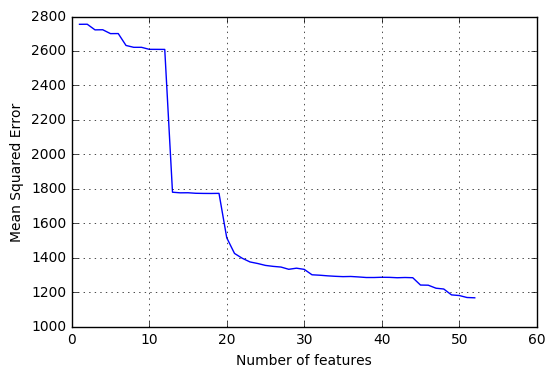

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
mse_df = pd.DataFrame(mse_dict.items(), columns=['num_parameters','mse'], index=mse_dict.keys())
plt.plot(mse_df['mse'])
plt.grid()
plt.xlabel('Number of features')
plt.ylabel('Mean Squared Error')

In [10]:
print mse_df.ix[10:25,'mse']

10    2609.377337
11    2609.200532
12    2608.844191
13    1779.730029
14    1776.173904
15    1776.586251
16    1773.560265
17    1772.725251
18    1772.463527
19    1773.062092
20    1515.002231
21    1424.229705
22    1396.215864
23    1374.837649
24    1365.727259
25    1354.678933
Name: mse, dtype: float64


<code>
The plot of number of MSE variation with the number of features in the model shows an 'elbow graph' at num_features = 21. Less than 21 features results in drastic increase in MSE. Increasing beyond 21 features doesn't show much decrease in MSE. 
So we choose 21 as the optimal number of features for our model. These features are:
</code>

In [11]:
y_true = df['price']
X=df.ix[:, 1:]

selector = RFE(linear_reg_model, n_features_to_select=21)
selector = selector.fit(X, y_true)

feature_ranks = pd.DataFrame(selector.ranking_, index=df.ix[:,1:].columns, columns=['ranking'])
print feature_ranks.head() # A dataframe to store the ranking of each feature

                      ranking
accommodates               11
bathrooms                   2
bedrooms                    1
beds                       13
Elevator in building        1


In [12]:
print feature_ranks['ranking'].value_counts()[:10] #Frequency counts of ranks

1     21
31     1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
Name: ranking, dtype: int64


<code>As seen above, 21 features were ranked 1 (i.e., most important)
1 feature was ranked 31
1 feature was ranked 2
and so on.
The 21 most important features are:
</code>

In [13]:
feature_ranks[feature_ranks['ranking']<2].ranking

bedrooms                            1
Elevator in building                1
minimum_nights_MN1                  1
minimum_nights_MN2                  1
minimum_nights_MN3                  1
minimum_nights_MN_                  1
instant_bookable_f                  1
instant_bookable_t                  1
num_page_saved_H                    1
num_page_saved_L                    1
num_page_saved_M                    1
cancellation_policy_flexible        1
cancellation_policy_moderate        1
cancellation_policy_strict          1
bed_type_Other                      1
bed_type_Real Bed                   1
room_type_Entire home/apt           1
room_type_Private room              1
room_type_Shared room               1
calculated_host_listings_count_M    1
calculated_host_listings_count_S    1
Name: ranking, dtype: int64

In [14]:
# Fit model and find MSE error
cols = ['price'] + list(feature_ranks[feature_ranks['ranking']<2].index)
df_new = df.ix[:,cols]
linear_reg_model.fit(X=df_new.ix[:, 1:], y=y_true)
y_pred = linear_reg_model.predict(df_new.ix[:,1:])
print mean_squared_error(y_true, y_pred)

1424.2297055


In [33]:
df_new.shape # 21 features and 1 y-variable

(9202, 22)

<code>Randoming doing an 80:20 split of the data

In [34]:
#MSE when 80% of the data is used to obtain a model (training), tested on the rest 20%
from sklearn.model_selection import train_test_split
X = df_new.ix[:,1:]
y_true = df_new['price']
linear_reg_model = LinearRegression()
for i in range (0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=i)
    linear_reg_model.fit(X_train, y_train)
    print("MSE with 80-20 split iteration %s : %0.2f" % (i+1 , mean_squared_error(y_test,linear_reg_model.predict(X_test))))
    i=i+1

MSE with 80-20 split iteration 1 : 1394.27
MSE with 80-20 split iteration 2 : 1388.09
MSE with 80-20 split iteration 3 : 1447.65
MSE with 80-20 split iteration 4 : 1387.13
MSE with 80-20 split iteration 5 : 1343.86
MSE with 80-20 split iteration 6 : 1393.17
MSE with 80-20 split iteration 7 : 1554.56
MSE with 80-20 split iteration 8 : 1384.01
MSE with 80-20 split iteration 9 : 1445.35
MSE with 80-20 split iteration 10 : 1267.46


<code>10-fold cross-validation done below.
The results are promising since the cross-validated MSE (=1429) is approximately close to the MSE when the entire data was used for both train and test (=1424).

In [35]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Randomly shuffling the records of the original data
df_new = df_new.reindex(np.random.permutation(X.index))
X = df_new.ix[:,1:]
y_true = df_new['price']

# 10-Fold CV
linear_reg_model = LinearRegression()
n_folds = 10
# negative MSE is the allowed argument for the scoring function - multiply by -1 to obtain the MSE
scores = -1.0*cross_val_score(linear_reg_model, X=X, y=y_true, cv=n_folds, scoring='neg_mean_squared_error') 
print scores
print "Average MSE from 10-fold CV:", scores.mean()

[ 1472.85287731  1395.53230609  1392.5297894   1440.22527174  1536.93551291
  1281.55763258  1499.76209345  1390.70631793  1407.4671875   1460.02282609]
Average MSE from 10-fold CV: 1427.7591815


### Residual Plots
<code>1) Plotting the histogram of error residuals
2) Plot of residuals vs X for each explanatory variable

The residuals are approximately normal distributed with mean =  -0.0173026244295


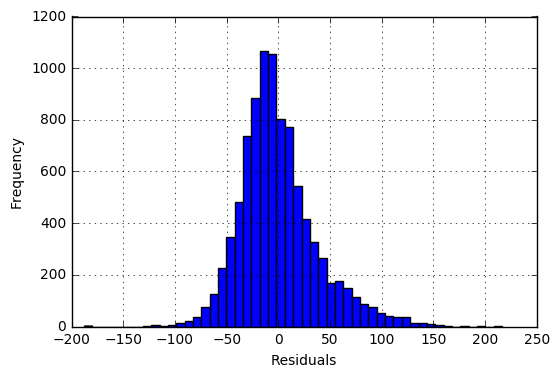

In [36]:
linear_reg_model.fit(X=df_new.ix[:,1:], y=y_true)
y_pred = linear_reg_model.predict(df_new.ix[:,1:])
residuals = y_true-y_pred
plt.hist(residuals, bins=50)
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("Residuals")
print "The residuals are approximately normal distributed with mean = ", residuals.mean()

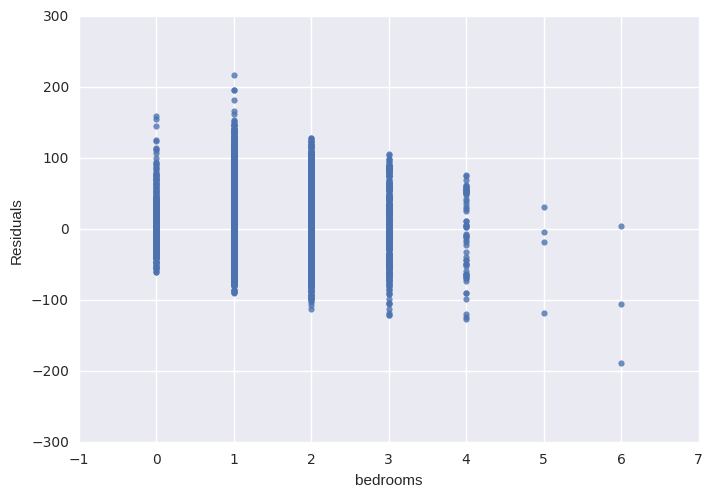

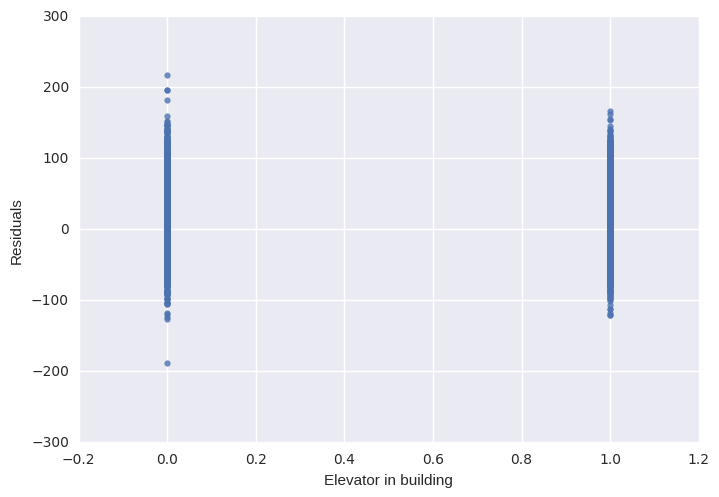

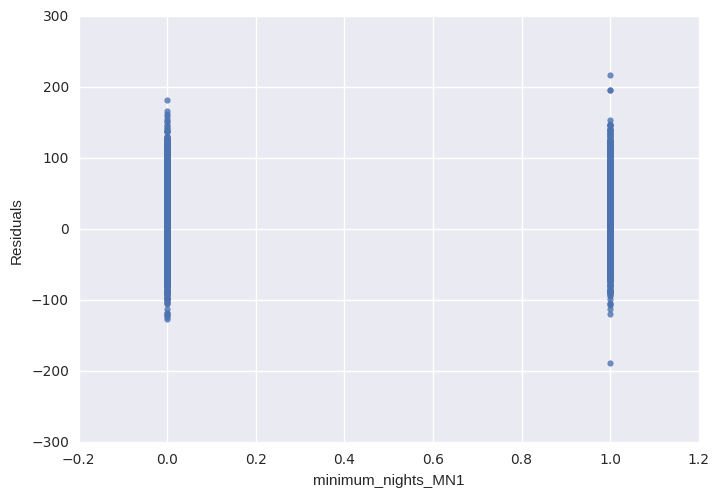

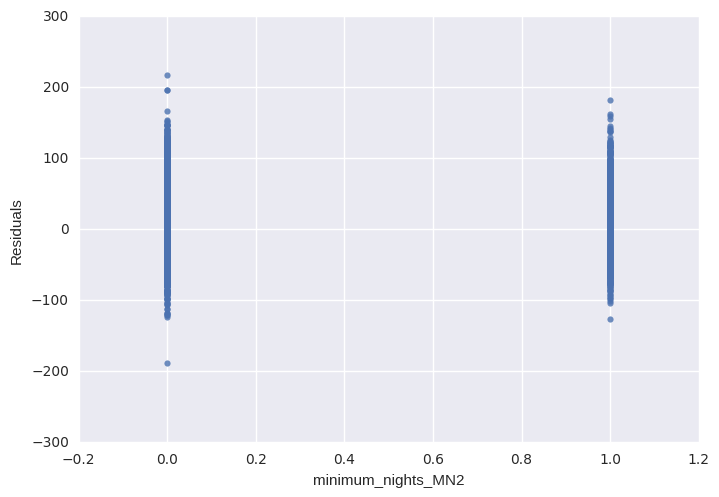

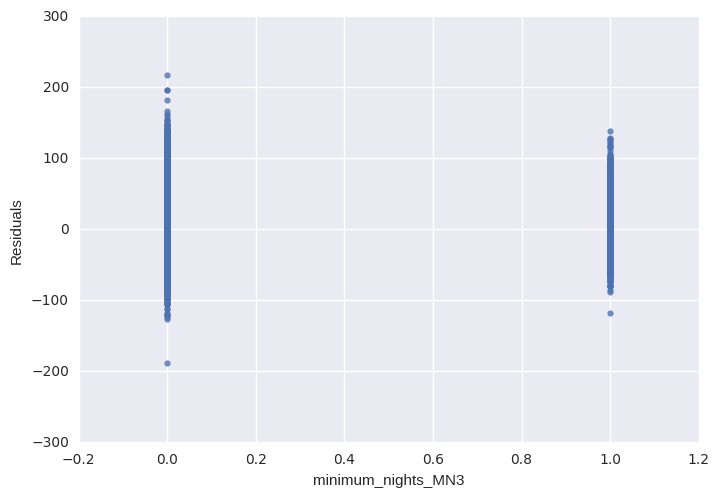

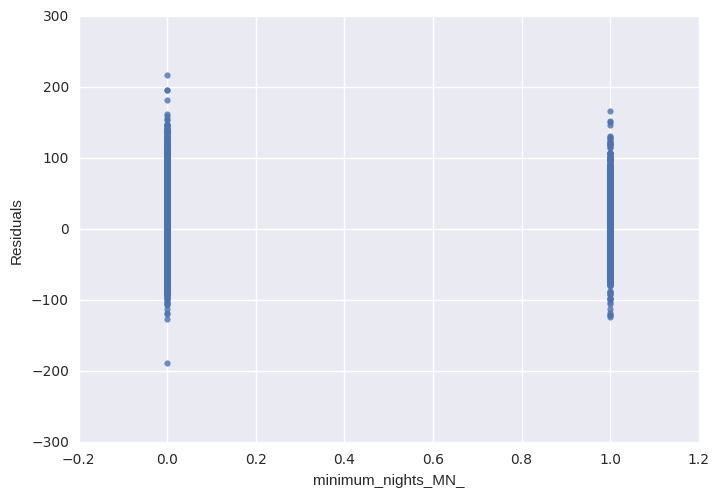

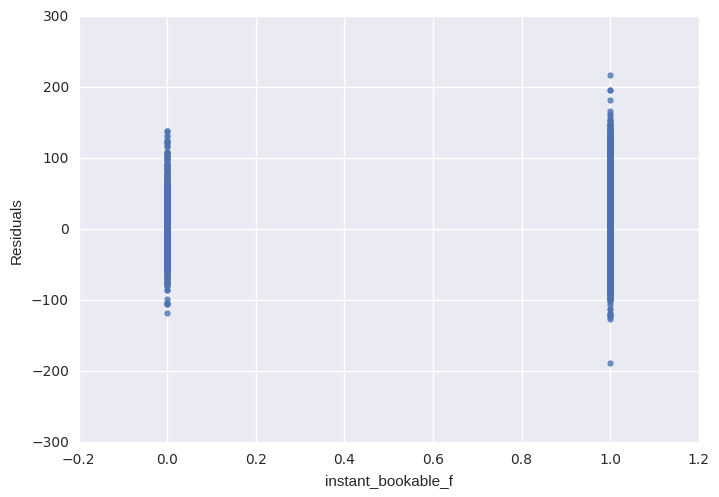

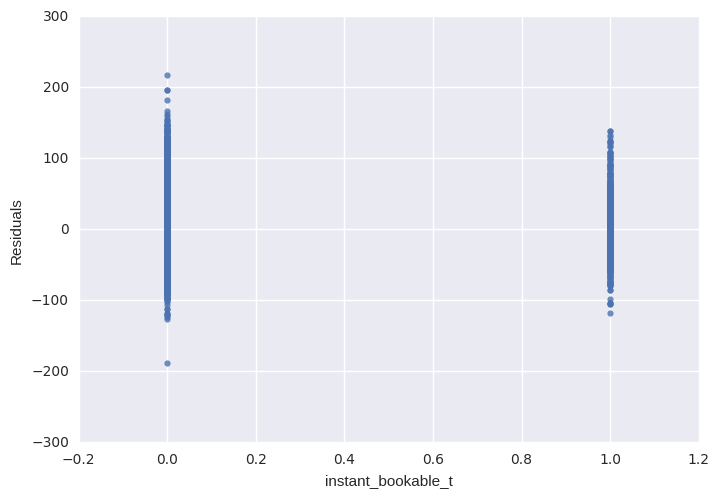

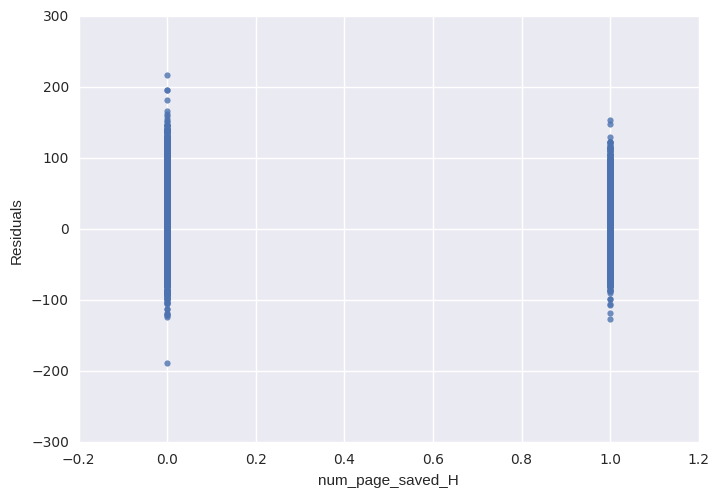

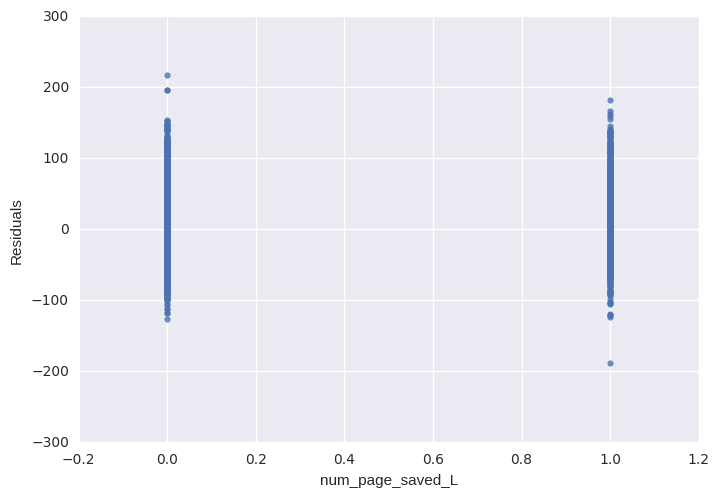

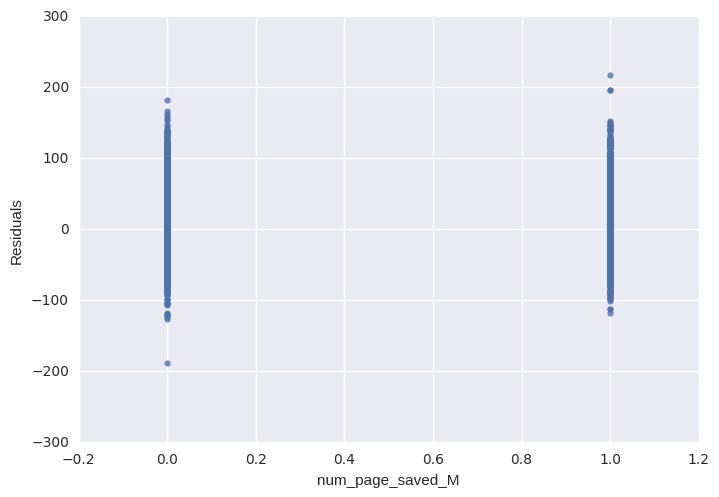

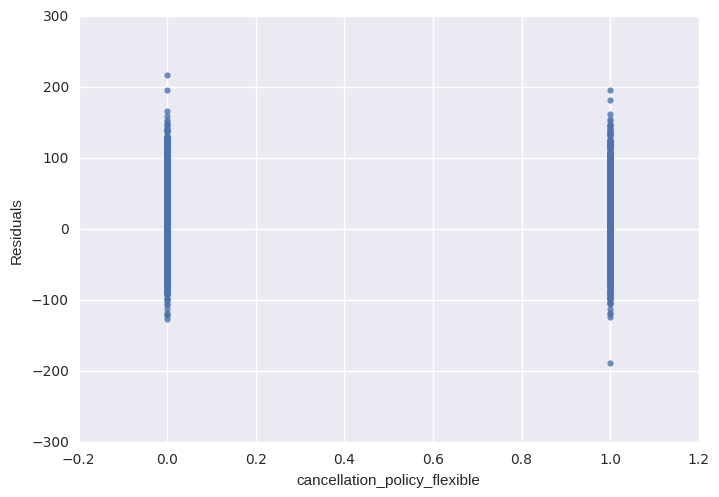

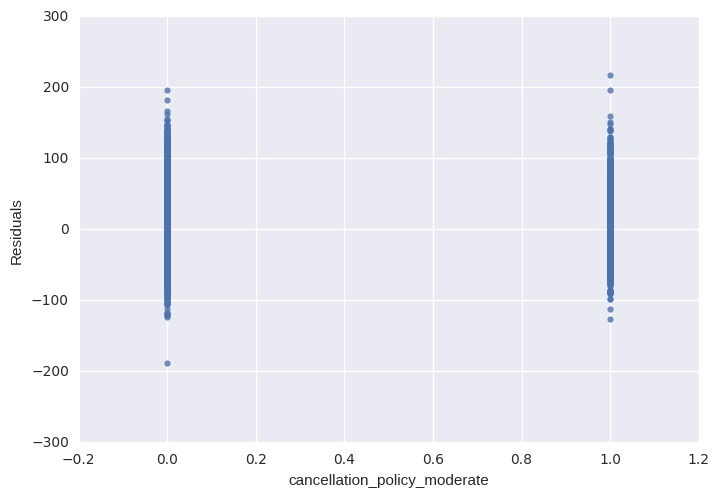

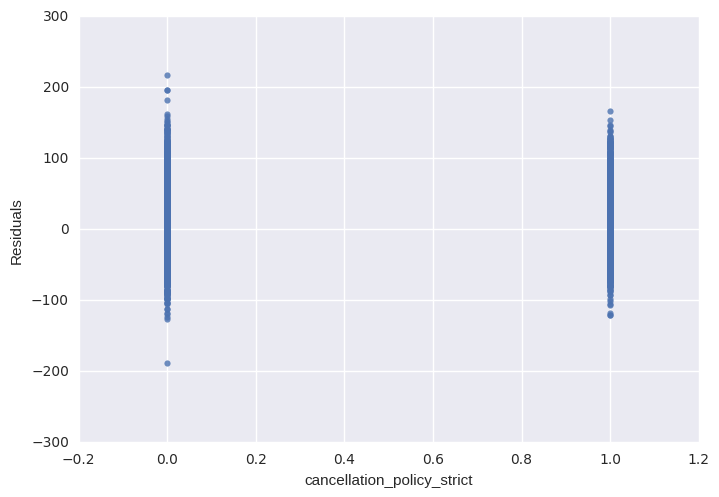

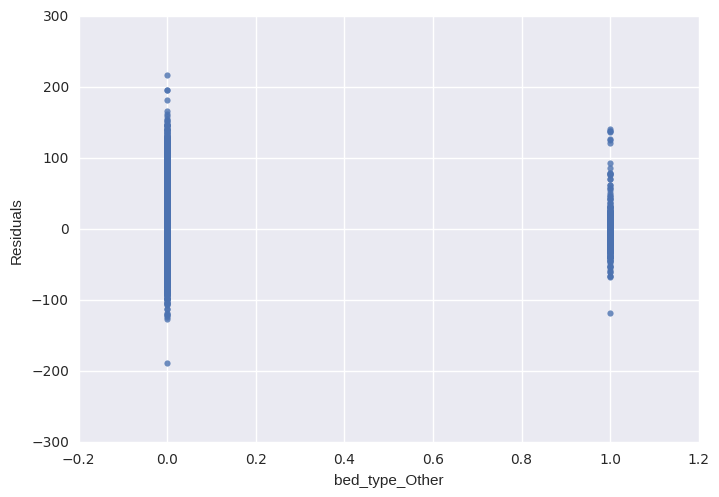

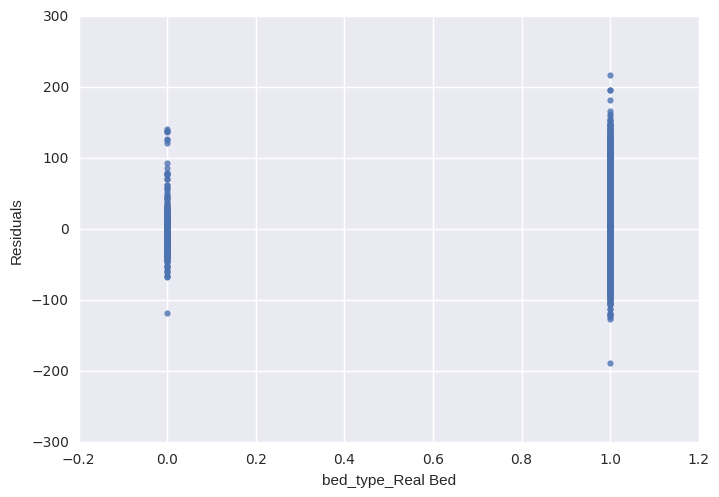

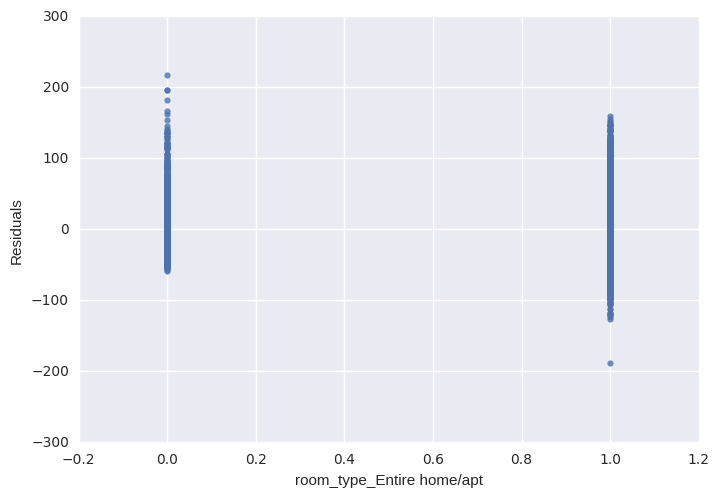

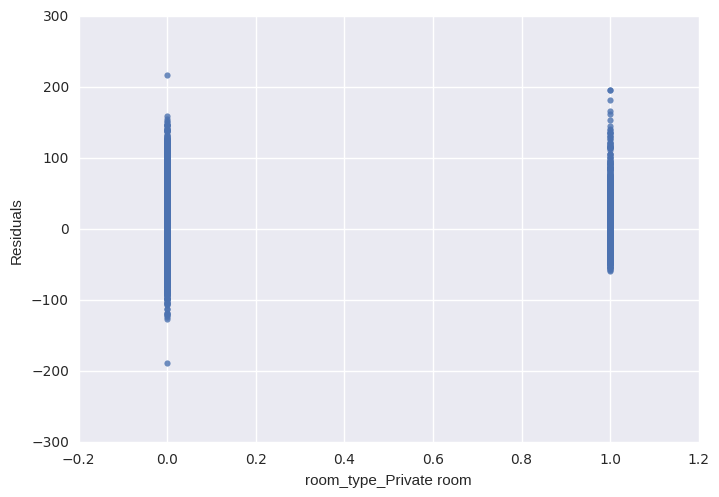

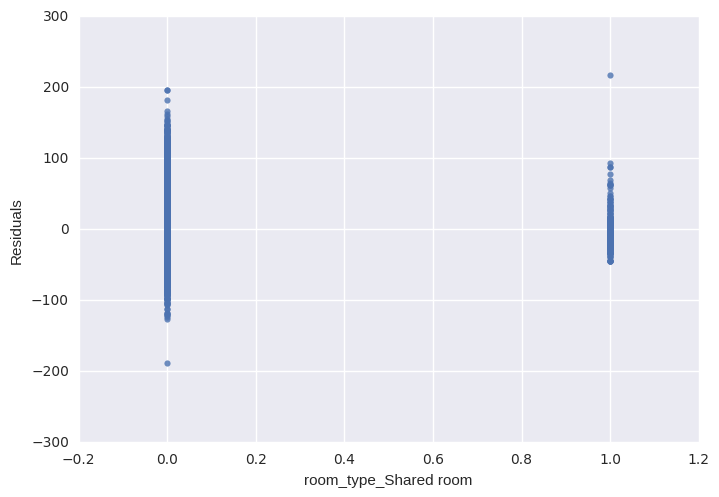

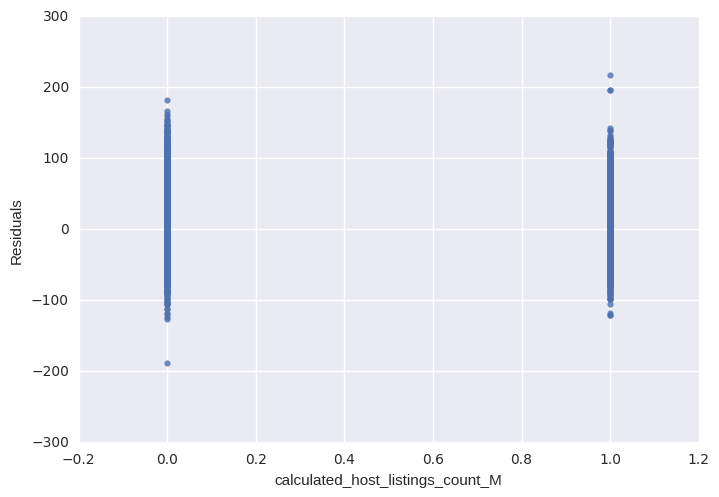

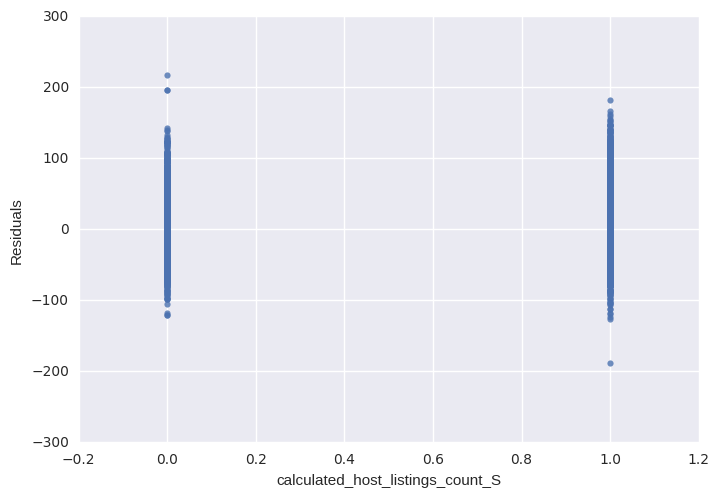

In [37]:
import seaborn as sns
features = df_new.ix[:,1:].columns
for feature in features:
    ax = sns.regplot(x=df_new[feature], y=residuals, fit_reg=False)
    ax.set(ylabel='Residuals')
    plt.show()

<code>All the variables seem to have no particular pattern in the residual plots.